#  Práctica 2 Información No Estructurada - 2022 - Master Ciencia de Datos UAM

## AUTORES: Miguel Carreras Lahoz,Adrián Rubio Pintado


In [5]:
import pandas as pd
import numpy as np
pd.set_option("display.precision", 9)


# EJERCICIO 1: Evaluación con juicios de relevancia

## Carga de Datos

Tenemos 5 ficheros:
    
- qrels.csv: que contiene los documentos relevantes identificados por cada query y cuantificando la relevancia en [0,2]
- buscador.csv: 4 documentos por cada buscador que agrupan las queries que se han hecho en él. De nuevo cada query viene identificada por un número

*Cabe destacar que el número de consultas escogido es 10, debido a que fue el número de consultas que se encontraban(bien presentadas tal y como se pedia en formato), el día de fin de recogida de datos para la práctica, especificado en moodle.*


**Por mantener la reproducibilidad de los resultados(y debido a un duplicado en uno de los archivos), se entregan también los .csv procesados y usados en la práctica**


In [691]:
N_OF_QUERIES = 10

In [692]:


############################################
#                Loading Data 
############################################


#Lectura de Rankings, por buscador, identificados por consulta
google = pd.read_csv('Google.csv')
bing = pd.read_csv('Bing.csv')
yandex = pd.read_csv('Yandex.csv')
duck = pd.read_csv('Duck.csv')

google = google.drop(['ignorar_campo'], axis=1)
bing = bing.drop(['ignorar_campo'], axis=1)
yandex = yandex.drop(['ignorar_campo'], axis=1)
duck = duck.drop(['ignorar_campo'], axis=1)

engines= { 'google': google,
           'bing': bing,
           'yandex': yandex,
           'duck':  duck
         }


In [693]:
google.head()

,query_id,URL,Posicion,Score,Buscador
0,0,http://www.cs.cmu.edu/~aberger/proposal.ps,1,10,google
1,0,http://ictir2015.org,2,9,google
2,0,https://en.wikipedia.org/wiki/Information_retr...,3,8,google
3,0,http://onlinelibrary.wiley.com/doi/10.1002/asi...,4,7,google
4,0,http://web4.cs.ucl.ac.uk/staff/jun.wang/papers...,5,6,google


In [694]:
#google.loc[google['query_id'] == 0]['URL']

Lectura de URLs relevantes. Solo consideramos relevantes las que tengan un nivel de acierto mayor a 0

In [695]:
#Leemos el fichero de relevante
#No relevante: 0
#Relevante: >0
qrels_with_zeros = pd.read_csv('qrels.csv')
qrels_with_zeros = qrels_with_zeros.drop_duplicates()
qrels_with_zeros.head()

,query_id,Ignorar_campo,URL,Nivel_de_acierto
0,0,0,http://ciir-publications.cs.umass.edu/getpdf.p...,0
1,0,0,http://citeseerx.ist.psu.edu/viewdoc/download?...,0
2,0,0,http://citeseerx.ist.psu.edu/viewdoc/summary?d...,2
3,0,0,http://dictionary.reference.com/browse/informa...,0
4,0,0,http://dl.acm.org/citation.cfm?id=2499178,0


Definimos las funciones de cálculo de métricas

## DEFINICION DE MÉTRICAS

## Precision, Recall y  Media Armónica.

Calculamos Precision como:
$$P = \frac{|Relevant \cap Returned|}{|Returned|}$$

Y Recall como:
$$R = \frac{|Relevant \cap Returned|}{|Relevant|}$$


La media armónica o F measure se define a partir de Precision y Recall tal que:
$$F = \frac{2RP}{R+P}$$

In [697]:
#calc_metrics_por_consulta(qrels.loc[qrels['query_id'] == 0] ,google.loc[google['qid'] == 0])
def calc_metrics_por_consulta(qi_rels, qi_returned):
    '''
        Calcula precision y recall para una consulta
        Args:
            qi_rels:urls  relvantes para la consulta i
            qi_returned: urls  returned para la consulta i
    '''
    intersection = pd.merge(qi_rels, qi_returned, how='inner', on=['URL'])

    precision = len(intersection)/len(qi_returned)
    recall = len(intersection)/len(qi_rels)
    m_armonica = (2*precision*recall)/ (precision + recall)
    return  precision, recall, m_armonica 
    
    





## MRR: Mean Reciprocal Rank

El RR o Reciprocal Rank está definido como el recíproco del ranking para el primer docomento relevante dentro del ranking. Es decir:
$$RR = \frac{1}{posicion(1erDocRelevante)}$$
El Mean Reciprocal Rank o MRR se define como la media de los RR's sobre un conjunto de queries.

In [698]:
def calc_RR_por_consulta(qi_rels, qi_returned):
    '''
        Calcula  Reciprocal Rank para una consulta
        Args:
            qi_rels:urls  relvantes para la consulta i
            qi_returned: urls  returned para la consulta i
    '''
    rr = 0 #in case no relevant doc is found in the ranking
    qi_ranking = qi_returned.sort_values(by=['Posicion'])
    
    for i in range(len(qi_ranking)):
        doc = qi_ranking.loc[qi_ranking['Posicion'] == i+1]
        #print('doc[URL]ggg',  doc['URL'].values[0])
    
        if(doc['URL'].values[0] in qrels['URL'].values):#if relevant
            rr = 1/doc['Posicion'].values[0]
            break
    return rr

## nDCG o normalized Discounted Cumulative Gain

Definimos el **nDCG o normalized Discounted Cumulative Gain** como

$$nDCG = \frac{DCG}{iDCG} $$

Siendo $$DCG = \sum_{d_{k} \in R} \frac{ rel(d_{k})}{ \log{k+1}} $$
y
$$ iDCG = \max{DCG(q)}  $$ 
es decir, para una consulta dada, el máximo DCG posible según los ordenes de relevancia en el ranking.

In [699]:
def calc_nDCG(qi_rels_with_zeros, qi_returned):
    '''Calcula nDCG = DCG/iDCG
        Args:
            qi_rels_with_zeros: urls relevantes 
            qi_returned: urls  returned para la consulta i
    '''

    relevancia = 0
    dcg_values = [] 
    
    qi_ranking = qi_returned.sort_values(by=['Posicion'])
    intersection = pd.merge(qi_ranking, qi_rels_with_zeros, how='left', on=['URL'])
    intersection = intersection.fillna(0)
    #print('interseccion left join')
    #print(intersection)
    
    #Calculing the iDCG: ideal DCG
    rels = intersection['Nivel_de_acierto']
    rels = rels.sort_values( ascending=False)
    divisor = [np.log2(i+2) for i in range(len(rels.values)) ]#position+1 starting in 1
    idcg_values = [i/j for i,j in zip(rels.values, divisor) ]
    #print('idcg_values', idcg_values)
    idcg = np.sum(idcg_values)
    #print('idcg', idcg)

    
    #Calculing the DCG
    for i in range(len(intersection)):
        position = i+1
        doc = intersection.loc[intersection['Posicion'] == position]
        relevancia = doc['Nivel_de_acierto'].values[0]
        dcg_values.append(relevancia / np.log2(position +1))
           
    dcg =  np.sum(dcg_values)
    #print('dcg', dcg)

    return dcg/idcg


Caculamos el **RBP: Rank Biased Precision** como
$$RBP = (1-p) \sum_{d_{k} \in R} p^{k-1} rel(d_{k}) $$

Siendo p la probabilidad de pasar al documento siguiente, que es constante en todas las posiciones. 𝑝 establece la “agresividad” del descuento por posición.
**Por defecto y decisión propia, para el cálculo de métrica, tomamos un valor p de:**

In [700]:
default_p = 0.1 #Escogemos este arbitrariamente para el calculo posterior automático de métricas

In [701]:
def calc_RBP(p, qi_rels_with_zeros, qi_returned):
    
    rbp_values = []
    
    qi_ranking = qi_returned.sort_values(by=['Posicion'])
    intersection = pd.merge(qi_ranking, qi_rels_with_zeros, how='left', on=['URL'])
    intersection = intersection.fillna(0)
    #print('interseccion left join')
    #print(intersection)
    
    #Calculing the RBP
    for i in range(len(intersection)):
        position = i+1
        doc = intersection.loc[intersection['Posicion'] == position]
        relevancia = doc['Nivel_de_acierto'].values[0]
        rbp_values.append( (p**(position-1)) *relevancia )
        
    rbp = np.sum( rbp_values)
    rbp = (1-p) * rbp # constant C= (1-p)
    return rbp

Definimos funciones para la automatización del cálculo de las métricas anteriores. Primero una funcion que realice todos los calculos a nivel de buscador(esto es para cada consulta calculando las métricas y luego promediando dichas métricas entre el total de consultas), y luego una función que automatiza esta última para todos los buscadores, mostrando los resultados en forma de tabla comparativa más abajo.

In [791]:

#calc_metrics_por_buscador(qrels ,google , N_OF_QUERIES)
def calc_metrics_por_buscador(qrels_with_zeros, qreturned_buscador, n_queries):
    '''
        Calcula Precision, Recall, media armonica , MRR,
            por buscardor, promediando llamando a la funcion tantas veces 
            como consultas haya
        Args:
            qrels:relevantes devueltas por el buscador indexadas por query_id
            qreturned_buscador:urls devueltas por el buscador indexadas por query_id
            n_queries: num of queries
        Return:
            Métricas
    '''
    
    precisions = []
    recalls = []
    m_armonicas = []
    rr_s = []
    n_dcgs = []
    rbps = []
    
    qrels = qrels_with_zeros.drop(qrels_with_zeros[qrels_with_zeros.Nivel_de_acierto == 0].index)

    for i in range(n_queries):
        #Filtering by query id
        qi_rels = qrels.loc[qrels['query_id'] == i]
        qi_returned        = qreturned_buscador.loc[qreturned_buscador['query_id'] == i]
        qi_rels_with_zeros = qrels_with_zeros.loc[qrels_with_zeros['query_id'] == i]
        
        #Metrics calc
        preci, recall, armonica = calc_metrics_por_consulta(qi_rels['URL'], qi_returned)
        rr = calc_RR_por_consulta(qi_rels['URL'], qi_returned)
        n_dcg =  calc_nDCG(qi_rels_with_zeros, qi_returned)
        rbp = calc_RBP(default_p, qi_rels_with_zeros, qi_returned)
        
        
        precisions.append(preci )
        recalls.append(recall )
        m_armonicas.append(armonica)
        rr_s.append(rr)
        n_dcgs.append(n_dcg)
        rbps.append(rbp)
        
    return np.average(precisions), np.average(recalls), np.average(m_armonicas), np.average(rr_s),np.average(n_dcgs), np.average(rbp)



def calc_metrics_all_engines(engines,qrels_with_zeros, n_queries):
    '''Calcula lás métricas de 'calc_metrics_por_buscador' para todos los motores de búsqueda de la
        práctica'''
        
    df_metrics = pd.DataFrame(columns=['Engine', 'Precision', 'Recall',  'Harmonic Mean', 'MRR', 'nDCG', 'RBP'])
  
    for name,buscador in engines.items():
        precision, recall, media_armonica, mrr, n_dcg, rbp = calc_metrics_por_buscador(qrels_with_zeros, buscador, n_queries)
        df_metrics = df_metrics.append({'Engine': name, 'Precision':precision , 'Recall':recall,  'Harmonic Mean':media_armonica,
                                        'MRR':mrr, 'nDCG':n_dcg, 'RBP':rbp}, ignore_index=True)
        
    return df_metrics

## Cálculo de las métricas.

In [792]:

metrics = calc_metrics_all_engines(engines,qrels_with_zeros, N_OF_QUERIES)

In [793]:
metrics
#metrics.loc[metrics['Engine'] == 'google']

,Engine,Precision,Recall,Harmonic Mean,MRR,nDCG,RBP
0,google,0.76,0.425876316,0.536532336,1.000000000,0.931842352,1.999999909
1,bing,0.70,0.387783412,0.490658442,0.850000000,0.864971908,1.999999899
2,yandex,0.59,0.320069263,0.408761961,0.866666667,0.839788963,1.999800000
3,duck,0.73,0.420005634,0.522685189,0.933333333,0.890582403,1.999999899


# Comprobación de resultados con librería externa

Testeamos los resultados por buscador. Para ello creamos un dataframe pandas en formato de entrada de la librería. 

**Librería de validación usada: ir_measures:** *https://github.com/terrierteam/ir_measures*

*Lás métricas disponibles se pueden econtrar en https://ir-measur.es/en/latest/measures.html*, aunque RBP no está soportado en la versión actual por la librería ir_measures.

In [705]:
import ir_measures 
from ir_measures import *

## **Transformamos los datos al formato de entrada de la librería**
*Dado que en formato dataframe no nos lo acepta, transformamos las entradas a formato de diccionario*

### Creando  la entrada  qrels(dict)

In [707]:
#qrels with relevants docs
qrels_check = qrels_with_zeros[['query_id', 'URL', 'Nivel_de_acierto']]
qrels_check = qrels_check.rename(columns={"URL": "doc_id", "Nivel_de_acierto": "relevance"})
qrels_check.head()

,query_id,doc_id,relevance
0,0,http://ciir-publications.cs.umass.edu/getpdf.p...,0
1,0,http://citeseerx.ist.psu.edu/viewdoc/download?...,0
2,0,http://citeseerx.ist.psu.edu/viewdoc/summary?d...,2
3,0,http://dictionary.reference.com/browse/informa...,0
4,0,http://dl.acm.org/citation.cfm?id=2499178,0


In [767]:
#Create run dictionary with the scores per query id for ONE SEARCH ENGINE
qrels_dict = {}
for qi in range(N_OF_QUERIES):
    d = {k: int(v) for (k, v) in zip(qrels_check.loc[qrels_check['query_id'] == qi]['doc_id'].values, qrels_check.loc[qrels_check['query_id'] == qi]['relevance'].values )}
    string = 'Q' + str(qi)
    qrels_dict[string] = d
#qrels_dict

### Creando la entrada   run(dict) para CADA MOTOR de búsqueda

In [718]:
#runs with rank for each query

google_run = google[['query_id','URL', 'Score']]
google_run = google_run.rename(columns={"URL": "doc_id", "Score": "score"})
google_run.head()

,query_id,doc_id,score
0,0,http://www.cs.cmu.edu/~aberger/proposal.ps,10
1,0,http://ictir2015.org,9
2,0,https://en.wikipedia.org/wiki/Information_retr...,8
3,0,http://onlinelibrary.wiley.com/doi/10.1002/asi...,7
4,0,http://web4.cs.ucl.ac.uk/staff/jun.wang/papers...,6


In [720]:
#Create run dictionary with the scores per query id for ONE SEARCH ENGINE
run_dict_google = {}
for qi in range(N_OF_QUERIES):
    d = {k: int(v) for (k, v) in zip(google_run.loc[google_run['query_id'] == qi]['doc_id'].values, google_run.loc[google_run['query_id'] == qi]['score'].values )}
    string = 'Q' + str(qi)
    run_dict_google[string] = d
#run_dict_google

Repetimos el proceso para los otros 3 motores:


In [762]:
#runs with rank for each query
bing_run = bing[['query_id','URL', 'Score']]
bing_run = bing_run.rename(columns={"URL": "doc_id", "Score": "score"})
bing_run.head()

#Create run dictionary with the scores per query id for ONE SEARCH ENGINE
run_dict_bing = {}
for qi in range(N_OF_QUERIES):
    d = {k: int(v) for (k, v) in zip(bing_run.loc[bing_run['query_id'] == qi]['doc_id'].values, bing_run.loc[bing_run['query_id'] == qi]['score'].values )}
    string = 'Q' + str(qi)
    run_dict_bing[string] = d
#run_dict_bing

In [763]:
#runs with rank for each query
yandex_run = yandex[['query_id','URL', 'Score']]
yandex_run = yandex_run.rename(columns={"URL": "doc_id", "Score": "score"})
yandex_run.head()

#Create run dictionary with the scores per query id for ONE SEARCH ENGINE
run_dict_yandex = {}
for qi in range(N_OF_QUERIES):
    d = {k: int(v) for (k, v) in zip(yandex_run.loc[yandex_run['query_id'] == qi]['doc_id'].values, yandex_run.loc[yandex_run['query_id'] == qi]['score'].values )}
    string = 'Q' + str(qi)
    run_dict_yandex[string] = d
#run_dict_yandex

In [764]:
#runs with rank for each query
duck_run = duck[['query_id','URL', 'Score']]
duck_run = duck_run.rename(columns={"URL": "doc_id", "Score": "score"})
duck_run.head()

#Create run dictionary with the scores per query id for ONE SEARCH ENGINE
run_dict_duck = {}
for qi in range(N_OF_QUERIES):
    d = {k: int(v) for (k, v) in zip(duck_run.loc[duck_run['query_id'] == qi]['doc_id'].values, duck_run.loc[duck_run['query_id'] == qi]['score'].values )}
    string = 'Q' + str(qi)
    run_dict_duck[string] = d
#run_dict_duck

In [811]:
#RBP Unsuported measure!!
#ir_measures.calc_aggregate([ P@10,R@10, RR@10, ,nDCG@10 ], qrels_dict_google, run_dict_google)

print('Google',ir_measures.calc_aggregate([ P@10,R@10, RR ], qrels_dict, run_dict_google) )
print('Bing',ir_measures.calc_aggregate([ P@10,R@10, RR ], qrels_dict, run_dict_bing) )
print('Yandex',ir_measures.calc_aggregate([ P@10,R@10, RR  ], qrels_dict, run_dict_yandex) )
print('Duck',ir_measures.calc_aggregate([ P@10,R@10, RR ],  qrels_dict, run_dict_duck) )




Google {R@10: 0.4199939631024824, P@10: 0.75, RR: 1.0}
Bing {R@10: 0.3877834122154609, P@10: 0.7, RR: 0.85}
Yandex {R@10: 0.31340259667085224, P@10: 0.5800000000000001, RR: 0.8666666666666668}
Duck {R@10: 0.415005634437683, P@10: 0.7200000000000001, RR: 0.95}


**Vemos como Precision, Recall y ReciprocalRank(MeanRR) nos coinciden en valores**
. Dado que Precision y Recall nos coinciden, **también coincide por definición la média armónica.**

Paara el caso de **nDCG**, dado que nuestra implementación es distinta a la proporcionada por la librería,que no tiene en cuenta la relevancia, además de que otros términos son ligeramente distintos, no nos dan resultados similares como es lógico, y por tanto no podemos usarla para validar. 

*El nDCG implementado por la librería puede encontrarse en el artículo doi.org/10.1145/582415.582418*

Para el caso de **RBP**, nos sucede algo similar, la versión actual de la herramienta produce error de "metrica no soportada" cuando llamamos a la librería. Por tanto no podemos usarla para validar nuestra implementación.

Sin embargo, para validarlas hemos comprobado para cada query_id=0, los cálculos manuales, para **validar** la implementación de estas dos últimas métricas **nDCG y RBP, con resultados satisfactorios.**

# Análisis de resultados

In [812]:
metrics

,Engine,Precision,Recall,Harmonic Mean,MRR,nDCG,RBP
0,google,0.76,0.425876316,0.536532336,1.000000000,0.931842352,1.999999909
1,bing,0.70,0.387783412,0.490658442,0.850000000,0.864971908,1.999999899
2,yandex,0.59,0.320069263,0.408761961,0.866666667,0.839788963,1.999800000
3,duck,0.73,0.420005634,0.522685189,0.933333333,0.890582403,1.999999899


De manera global vemos como todas las métricas vienen a comportarse de manera similar en todos los buscadores, como vemos a continuación, sin tener ninguna de ellas ningún comportamiento anómalo aparente a primera vista:

<AxesSubplot:xlabel='Engine'>

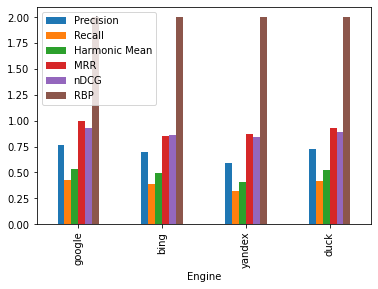

In [823]:
metrics.plot.bar(x='Engine', )

### Precision
Vemos como el Yandex es el buscador que peor se comporta mostrando probabilisticamente hablando, cosas más irrelevantes.

<AxesSubplot:xlabel='Engine'>

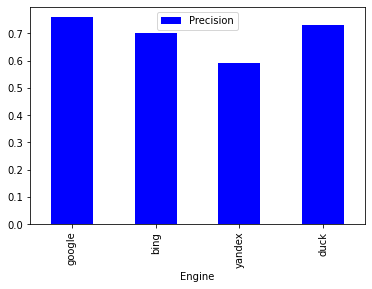

In [852]:
metrics.plot.bar(x='Engine', y ='Precision',color = 'blue')

### Recall
De nuevo pierde Yandex,seguido de Bing de nuevo. Vemos como Yandex también es el buscador que más cosas pierde probabilísticamente hablando.

<AxesSubplot:xlabel='Engine'>

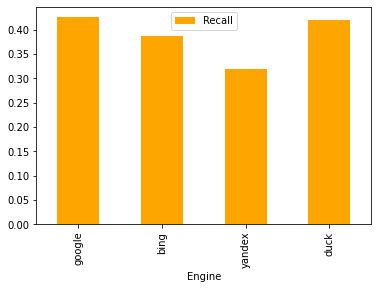

In [853]:
metrics.plot.bar(x='Engine', y ='Recall',color = 'orange')

### Media Armónica:
Siendo un balance entre Precision y Recall, como para ambas teníamos el mismo ranking de motores, Yandex sigue siendo el perdedor aquí.

<AxesSubplot:xlabel='Engine'>

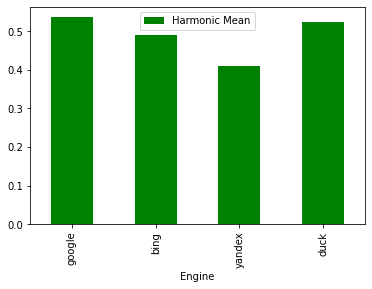

In [854]:
metrics.plot.bar(x='Engine', y ='Harmonic Mean',color = 'green')

### MRR:
Vemos como de alto publican los buscadores el resultado más relevante. De nuevo Google sigue siendo el mejor en todos los rankins con un valor máximo de 1, seguido sorprendentemente de DuckDcukGo, quedando por encima de Bing.
Yandex de nuevo es el buscador que peor se comporta bajo esta métrica de media.

<AxesSubplot:xlabel='Engine'>

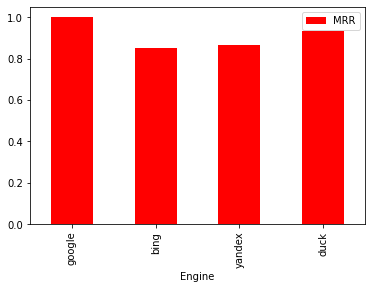

In [855]:
metrics.plot.bar(x='Engine', y ='MRR',color = 'red')

### nDCG 
Podemos interpretar nDCG como 'la utilidad a esperar' del usuario que sigue un modelo en cascada de clickado en el ranking mostrado de resultados, formalizado de una manera probabilística.

Vemos como Duck supera a Bing de nuevo, siguiendo Google como ganador y Yandex como perdedor.

<AxesSubplot:xlabel='Engine'>

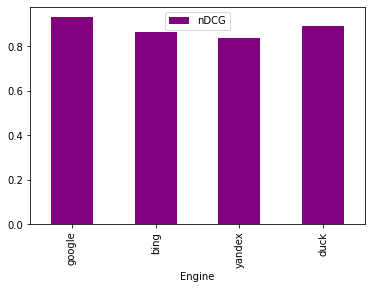

In [856]:
metrics.plot.bar(x='Engine', y ='nDCG',color = 'purple')

### RBP 
Considerando el uso de funciones de utilidad, con p = 0.1 todos los buscadores se comportan de modo similar.

<AxesSubplot:xlabel='Engine'>

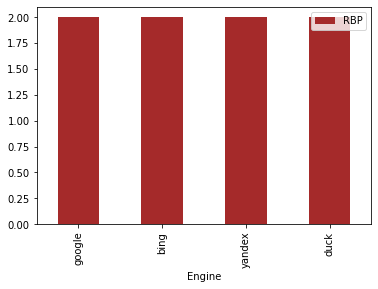

In [857]:
metrics.plot.bar(x='Engine', y ='RBP',color = 'brown')

**Probamos ahora con valores de p más agresivos: 0.25,0.5 y 0.75:**

<AxesSubplot:xlabel='Engine'>

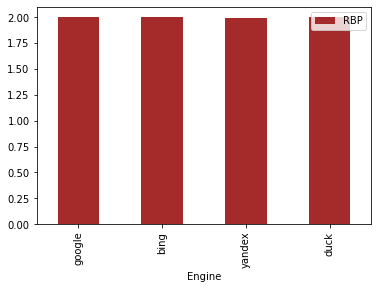

In [860]:
default_p = 0.25 #Escogemos este arbitrariamente para el calculo posterior automático de métricas
metrics_p_0_25 = calc_metrics_all_engines(engines,qrels_with_zeros, N_OF_QUERIES)
metrics_p_0_25.plot.bar(x='Engine', y ='RBP',color = 'brown')

<AxesSubplot:xlabel='Engine'>

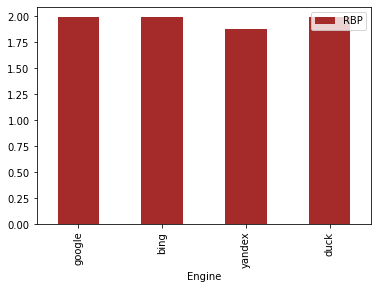

In [861]:
default_p = 0.5 #Escogemos este arbitrariamente para el calculo posterior automático de métricas
metrics_p_0_5 = calc_metrics_all_engines(engines,qrels_with_zeros, N_OF_QUERIES)
metrics_p_0_5.plot.bar(x='Engine', y ='RBP',color = 'brown')

<AxesSubplot:xlabel='Engine'>

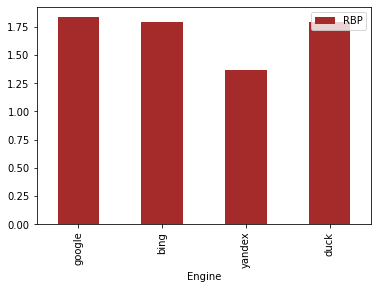

In [862]:
default_p = 0.75 #Escogemos este arbitrariamente para el calculo posterior automático de métricas
metrics_p_0_75 = calc_metrics_all_engines(engines,qrels_with_zeros, N_OF_QUERIES)
metrics_p_0_75.plot.bar(x='Engine', y ='RBP',color = 'brown')

**Notamos una diferencia únicamente con un valor de p alto, que pondere al 75% la relevancia de cada documento (siedo 1-p una cte. de normalización)**

En este caso google sale ligeramente el mejor parado, aunque Bing y DuckDuckGo obtienen resultados MUY similares. Yandex en cambio es el primero en "desplomarse" y quedar ante la última métrica como el peor.

# Conclusiones

Vemos como para todas las métricas de calidad mediante juicios de relvancia, Google se posiciona como el buscador por excelencia. Seguido por Bing o DuckDuckGo, según la métrica evaluada, aunque en general con resultados parecidos a Google. Yandex en cambio, por su parte, queda último en la totaldad de métricas, declarándose como el peor buscador de entre los 4 comparados, de acuerdo a la relevancia de los resultados que arroja. **Tal vez esto se deba a que es un buscador ruso, y tenga menos documentos en español que sus competidores, y además se desempeñe mejor, o relegue un parte de esa mejora de funcionamiento, a trabajar sobre un alfabeto distinto como es el alfabeto cirílico.**

-----------------

# PARTE 2: Métricas de Negocio
En primer lugar, comenzamos cargado los archivos derivados del simulador de comportamiento de usuarios frente a nuestros resultado de búsqueda

In [6]:
import matplotlib.pyplot as plt

In [7]:
# Cargamos los archivos generados y eliminamos los clicks de los buscadores intercalados
click_log = pd.read_csv('engagement-log.txt', sep = "\t")
impresion = pd.read_csv('impressions.txt', sep = '\t')

click_log = click_log[click_log.system != 'google+bing']
impresion = impresion[impresion.system != 'google+bing']

In [8]:
# Comprobamos que nuestros dfs estén completos
print("¿Existen valores nulos?: \n",click_log.isnull().any())

print("¿Existen valores nulos?: \n",impresion.isnull().any())

¿Existen valores nulos?: 
 system       False
timestamp    False
ip           False
qid          False
pos          False
docid        False
click        False
purchase     False
dtype: bool
¿Existen valores nulos?: 
 system       False
timestamp    False
ip           False
qid          False
dtype: bool


## Click por consulta

Definimos click por búsqueda como el número de clicks registrados por cada consulta, por buscador. 

In [10]:
# Para ello, agrupamos por buscador y contamos los clicks por consulta y buscador. 
# Una vez agrupados, calculamos la media de los click por buscador

cpc = click_log.groupby(by = ["system","qid"])["click"].count()
cpc = cpc.groupby(["system"]).mean()
# print(cpc)

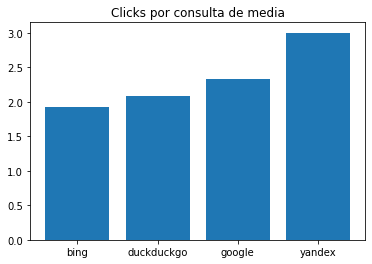

In [11]:
buscadores = ["bing","duckduckgo","google","yandex"]

plt.bar(buscadores,cpc)
plt.title("Clicks por consulta de media")
plt.show()

## Tasa de abandono

En este caso, la tasa de abandono está definida como el porcentaje de consultas que acaban sin ningún click, de nuevo, para cada buscador

In [12]:
# Para ello, agrupamos de nuevo las consultas realizadas y mediante un map comprobamos 
# si están todas las consultas representadas (13 consultas en total)

tda = impresion.groupby(by = ["system","qid"])["qid"].count()
num_consultas = max(click_log["qid"])+1 #de la 0 a la 12
# print(np.shape(tda))

tda.map(lambda e: 1)
tda = 1-tda.groupby(["system"]).count()/num_consultas

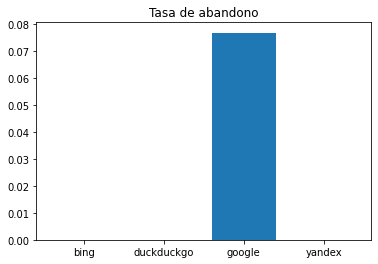

In [13]:
plt.bar(buscadores,tda)
plt.title("Tasa de abandono")
plt.show()

## Max RR

Esta métrica está definida como el valor medio de $\frac{1}{r}$ siendo $r$ el rango del resultado visitado con mayor rango. Matemáticamente: $$Max RR = \frac{1}{|Q|}\sum_{q_i}^{Q} \frac{1}{max(rank_{q_i})}$$

In [14]:
# Para ello, calculamos los rangos máximos y mediante una función map calculamos el inverso. 

maxrr = click_log.groupby(by = ["system","qid"])["pos"].min()
maxrr = maxrr.map(lambda e: 1/e)

maxrr = maxrr.groupby(["system"]).mean()

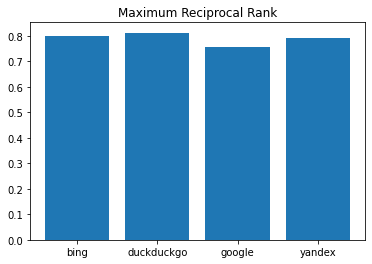

In [15]:
plt.bar(buscadores,maxrr)
plt.title("Maximum Reciprocal Rank")
plt.show()

## Mean RR

Siguiendo un razonamiento similar al $MaxRR$, el $MeanRR$ está definido como el valor medio de la media del inverso de las posiciones de cada URL por búsqueda y por buscador. En otras palabras:
$$Mean RR = \frac{1}{|Q|}\sum_{q_i}^{Q} \frac{1}{|Clk_{q_i}|}\sum_{j}^{q_i}\frac{1}{rank(j)_{q_i}}$$

In [16]:
# Para ello, como ya hemos hecho con el maxRR, calculamos la media en vez del máximo y 
# mediante la función map obtenemos los inversos de los rangos

meanrr = click_log.groupby(by = ["system","qid"])["pos"].mean()
meanrr = meanrr.map(lambda e: 1/e)
meanrr = meanrr.groupby(["system"]).mean()

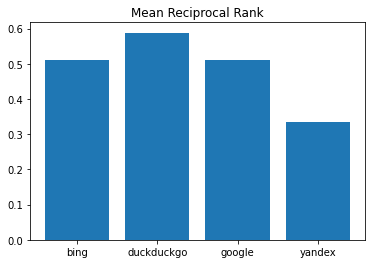

In [17]:
plt.bar(buscadores,meanrr)
plt.title("Mean Reciprocal Rank")
plt.show()

## Unidades vendidas

Finalmente, como su propio nombre indica, sumamos las unidades vendidas por cada buscador.

In [18]:
# Para ello, con una simple agrupación por buscador podemos sumar las compras ("purchase") realizadas.

uv = click_log.groupby(by = ["system"])["purchase"].count()

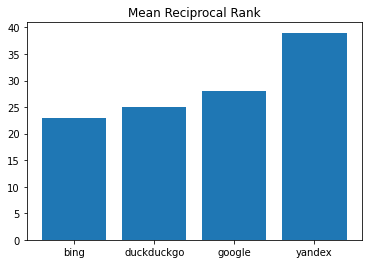

In [19]:
plt.bar(buscadores,uv)
plt.title("Mean Reciprocal Rank")
plt.show()

Por último, guardaremos en un dataframe cada una de las métricas estudiadas para hacer una valoración global de cada buscador. 

In [20]:
# Dataframe conjunto

d = {'Click/consulta': cpc, 'Tasa de abandono': tda,'Max RR': maxrr,'Mean RR':meanrr,'Unidades vendidas': uv}
df = pd.DataFrame(data=d)
df

,Click/consulta,Tasa de abandono,Max RR,Mean RR,Unidades vendidas
system,,,,,
bing,1.916666667,0.000000000,0.800000000,0.511111111,23
duckduckgo,2.083333333,0.000000000,0.812500000,0.588392857,25
google,2.333333333,0.076923077,0.757275132,0.510059184,28
yandex,3.000000000,0.000000000,0.791666667,0.334762612,39


## CONCLUSIONES 
Por último, destacaremos los buscadores que mejores métricas han tenido: 

Por ejemplo, Yandex ha sido el que más clicks por consulta ha recibido y además, lógicamente, el que más unidades ha vendido. 

Por otro lado, las métricas de Max RR y Mean RR han sido dominadas por duckduckgo. Aunque no ha habido mucha diferencia entre esta y los dos siguientes buscadores, en el caso de Mean RR Yandex ha sido la clara perdedora.

Con respecto a la tasa de abandono hemos comprobado que google ha sido el único buscador con alguna búsqueda sin click. 